# Timescale Associations - Exclude low tSNR

In [1]:
fmri_data_label = None
dwi_data_label = None
roi_subset = None
results_dir = None
resource_dir = None

In [2]:
# Parameters
dwi_data_label = "Yeh-HCP842"
results_dir = "/home/despo/dlurie/Projects/timescale_hierarchy/results"
resource_dir = "/home/despoB/dlurie/Projects/timescale_hierarchy/data/resources"
fmri_data_label = "HCP_Shine1_Session1_CleanGSR"
roi_subset = "CX"

In [3]:
import sys
import os
from copy import copy
from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from stat import S_IREAD, S_IRGRP, S_IROTH

In [4]:
sys.path.append('/home/despo/dlurie/Projects/timescale_hierarchy/code/scripts/')
sys.path.append('/home/despo/dlurie/Projects/PyPALM/')

In [5]:
import pypalm as pm
import utils

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette("colorblind")
pal = copy(plt.cm.autumn_r)
pal.set_bad('lightgrey')

In [7]:
gamma_range = np.arange(5,36,1) / 10

In [8]:
fc_pc_df, fc_wd_df = utils.load_cartography(f'{results_dir}/functional_connectivity/{fmri_data_label}_BNA_zmat_mean_po_Cartography/', 'MegaPart')
sc_pc_df, sc_wd_df = utils.load_cartography(f'{results_dir}/structural_connectivity/{dwi_data_label}_BNA_log_count_mat_Louvain')
sc_degree_df = pd.read_csv(f'{results_dir}/structural_connectivity/{dwi_data_label}_BNA_degree_df.tsv', delimiter='\t', index_col=0)
fc_degree_df = pd.read_csv(f'{results_dir}/functional_connectivity/{fmri_data_label}_BNA_degree_df.tsv', delimiter='\t', index_col=0)
ts_df = pd.read_csv(f'{results_dir}/timescales/{fmri_data_label}_BNA_timescale_df.csv')
roi_vols = np.genfromtxt(f'{resource_dir}/BNA-maxprob-thr25-2mm_ROI_volumes.txt')

In [9]:
tsnr_df = pd.read_csv(f'{results_dir}/timescales/{fmri_data_label}_BNA_tSNR.tsv', index_col=0)

In [10]:
dat = pd.DataFrame(np.array([sc_degree_df.log_count_strength.values,
                             fc_degree_df.strength_zmean_po.values,
                             ts_df.lag1_median.values, roi_vols,
                             tsnr_df.tmean, tsnr_df.PPtsnr, tsnr_df.tsd]).T,
                   columns = ['sc_strength', 'fc_strength', 'lag1', 'roi_vols', 'tmean','PPtsnr','tsd'])

In [11]:
if roi_subset == 'CX':
    dat = dat[:210]
    
    myelin = np.genfromtxt('/home/despo/dlurie/Projects/timescale_hierarchy/data/hcp/group_average/S1200/HCP-S1200_BNA_myelin.txt')
    myelin_ordered = utils.reorder_BNA_ctx_ROIs(myelin)
    dat['myelin'] = myelin_ordered
    
    corr_thickness = np.genfromtxt('/home/despo/dlurie/Projects/timescale_hierarchy/data/hcp/group_average/S1200/HCP-S1200_BNA_corr_thickness.txt')
    ct_ordered = utils.reorder_BNA_ctx_ROIs(corr_thickness)
    dat['ct'] = ct_ordered
    
    fc_pc_df = fc_pc_df[:210]
    sc_pc_df = sc_pc_df[:210]
    fc_wd_df = fc_wd_df[:210]
    sc_wd_df = sc_wd_df[:210]

In [12]:
lag1_vs_roiv_yhatperm = np.load(f'{results_dir}/stats/timescale_associations/{fmri_data_label}_BNA_{roi_subset}_Lag1_vs_ROIv_yhatperms.npy')

In [24]:
PPtsnr_T10 = dat.PPtsnr >= stats.scoreatpercentile(dat.PPtsnr, 10)

### Functional Connectivity Strength

In [25]:
lag1_vs_fck_rval, lag1_vs_fck_pvals, lag1_vs_fck_model, lag1_vs_fck_rnull = pm.freedman_lane(dat[PPtsnr_T10], 'lag1', 'fc_strength', 'roi_vols',
                                                                                             stat='pcorr', n_perms=10000, perm_func=None,
                                                                                             perm_func_args=None, surrogates=lag1_vs_roiv_yhatperm[:,PPtsnr_T10],
                                                                                             return_null=True, return_surrogates=False)

In [26]:
lag1_vs_fck_rval

0.12394587802889069

In [27]:
lag1_vs_fck_pvals

p_greater    0.213579
p_less       0.786521
p_abs        0.442256
dtype: float64

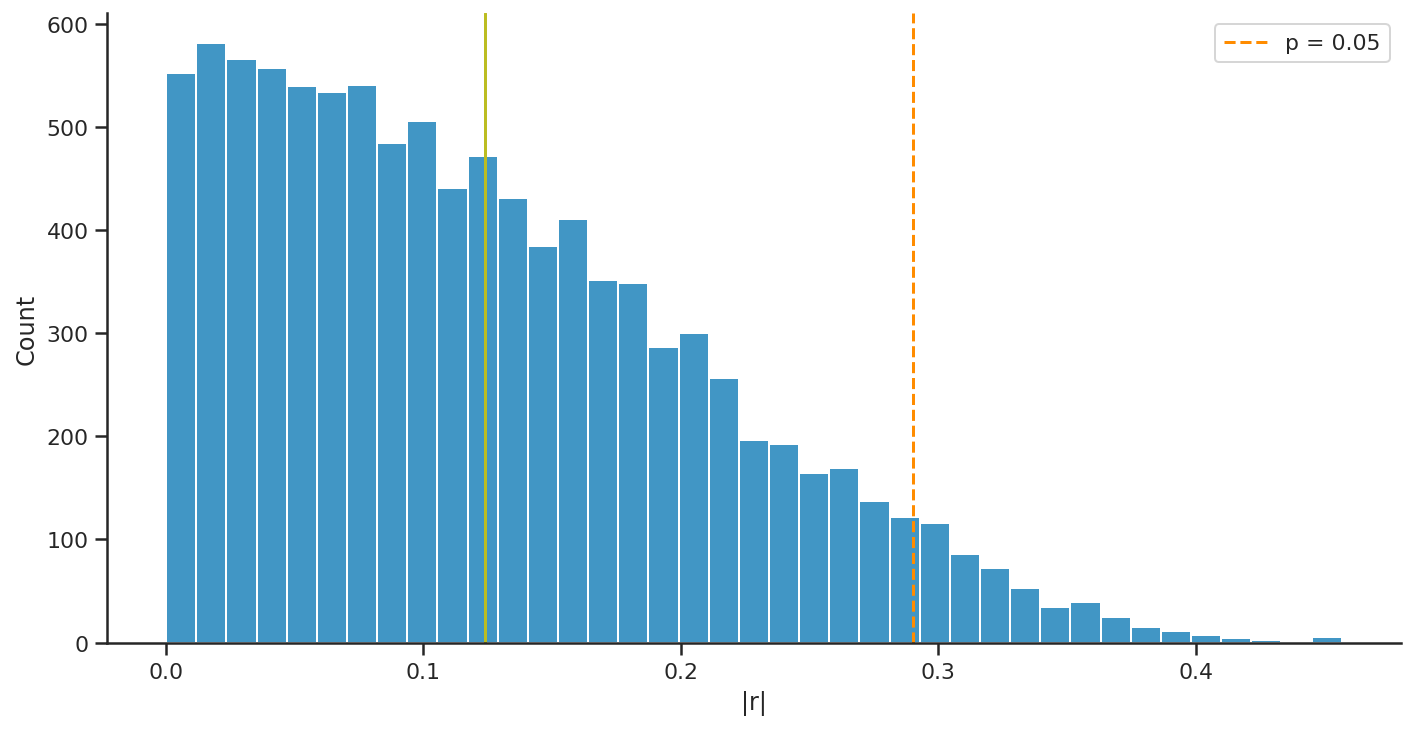

In [28]:
utils.plot_null_hist(lag1_vs_fck_rval, lag1_vs_fck_rnull)

### Structural Connectivity Strength

In [29]:
lag1_vs_sck_rval, lag1_vs_sck_pvals, lag1_vs_sck_model, lag1_vs_sck_rnull = pm.freedman_lane(dat[PPtsnr_T10], 'lag1', 'sc_strength', 'roi_vols',
                                                                                             stat='pcorr', n_perms=10000, perm_func=None, 
                                                                                             perm_func_args=None, surrogates=lag1_vs_roiv_yhatperm[:,PPtsnr_T10], 
                                                                                             return_null=True, return_surrogates=False)

In [30]:
lag1_vs_sck_rval

0.43279417608572923

In [31]:
lag1_vs_sck_pvals

p_greater    0.0001
p_less       1.0000
p_abs        0.0001
dtype: float64

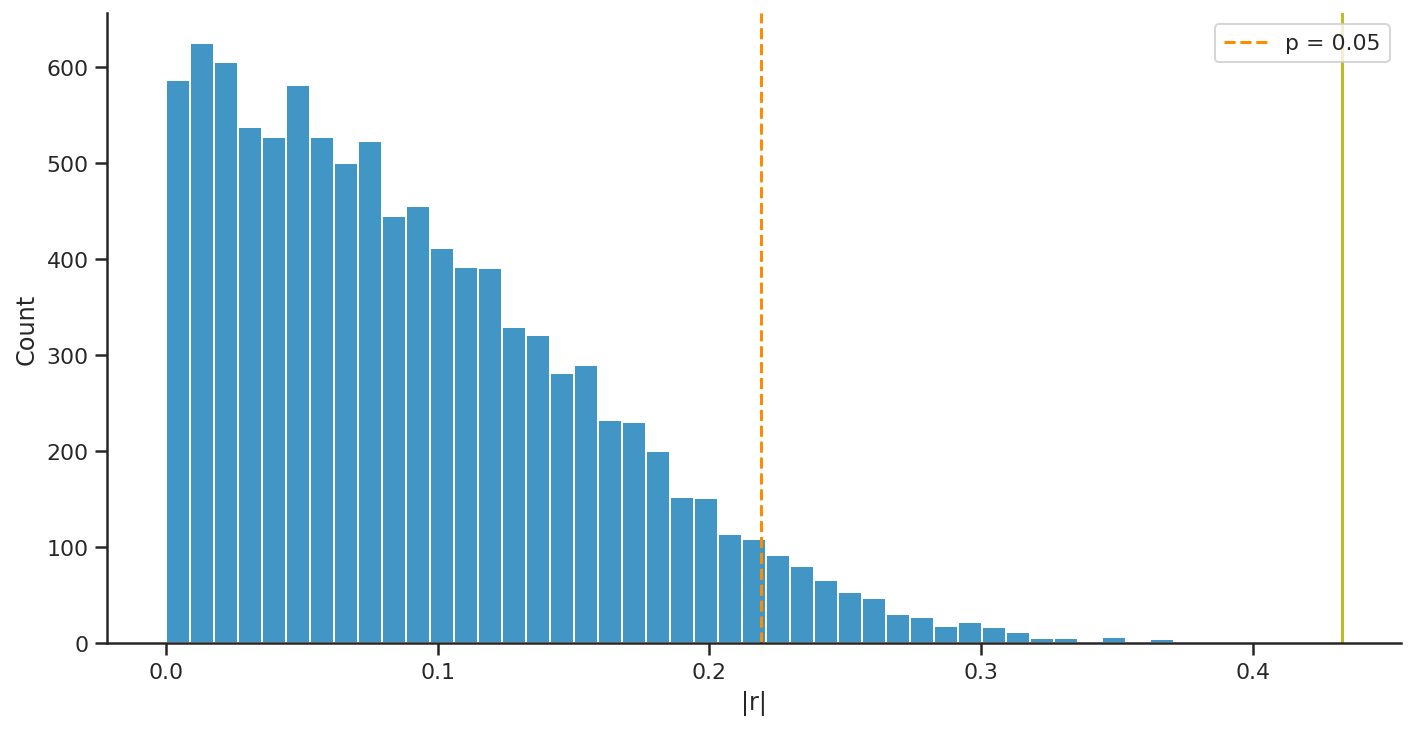

In [32]:
utils.plot_null_hist(lag1_vs_sck_rval, lag1_vs_sck_rnull)

### Functional Connectivitity Within-Module Degree (z-scored)

In [33]:
fc_wd_vs_lag1_df = utils.run_cartography_tests(gamma_range, dat[PPtsnr_T10], fc_wd_df[PPtsnr_T10], 'lag1', 'fc_wd', 'roi_vols', lag1_vs_roiv_yhatperm[:,PPtsnr_T10])

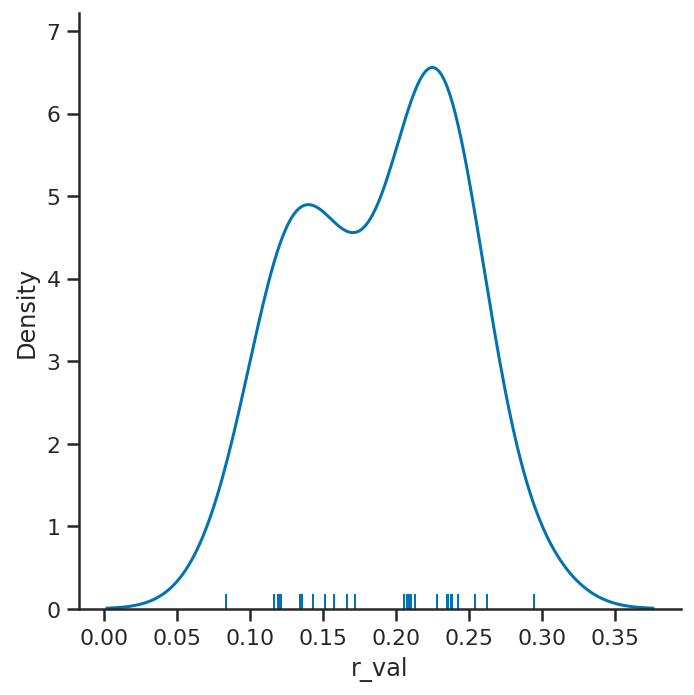

In [34]:
sns.set_style('ticks')
sns.displot(fc_wd_vs_lag1_df.r_val, kind='kde', rug=True)

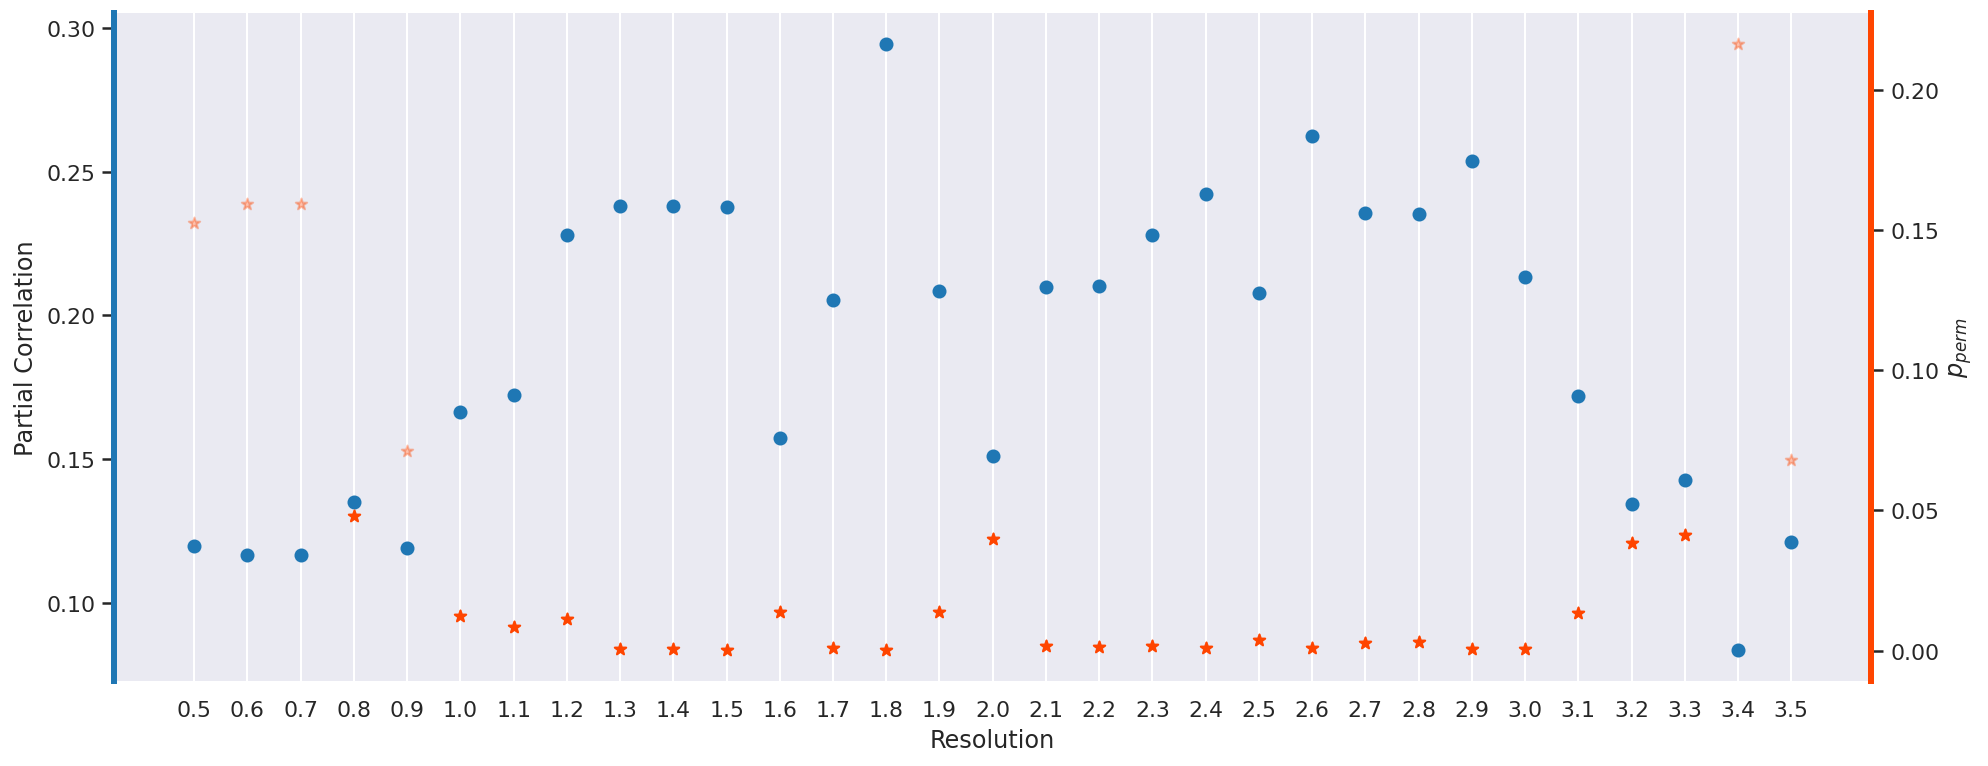

In [35]:
utils.plot_cart_test(fc_wd_vs_lag1_df.gamma, fc_wd_vs_lag1_df.r_val, fc_wd_vs_lag1_df.p_abs)

### Structural Connectivitity Within-Module Degree (z-scored)

In [36]:
sc_wd_vs_lag1_df = utils.run_cartography_tests(gamma_range, dat[PPtsnr_T10], sc_wd_df[PPtsnr_T10], 'lag1', 'sc_wd', 'roi_vols', lag1_vs_roiv_yhatperm[:,PPtsnr_T10])

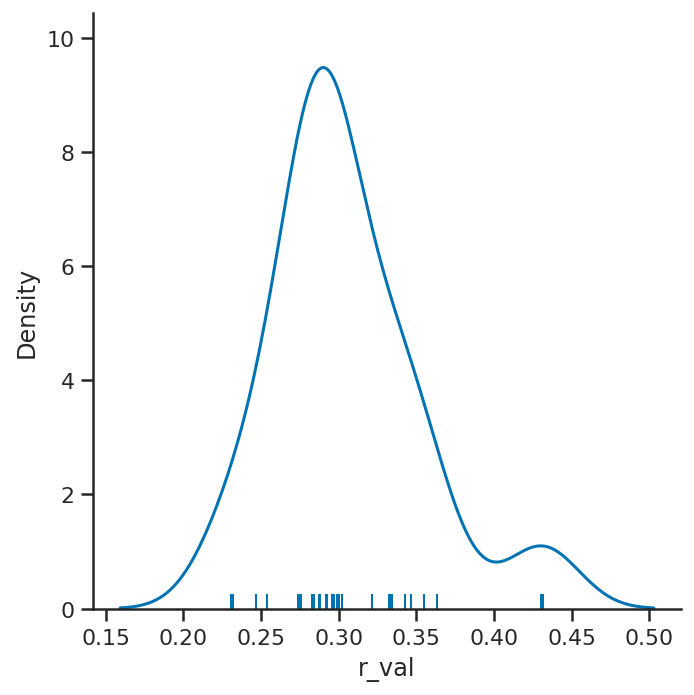

In [37]:
sns.set_style('ticks')
sns.displot(sc_wd_vs_lag1_df.r_val, kind='kde', rug=True)

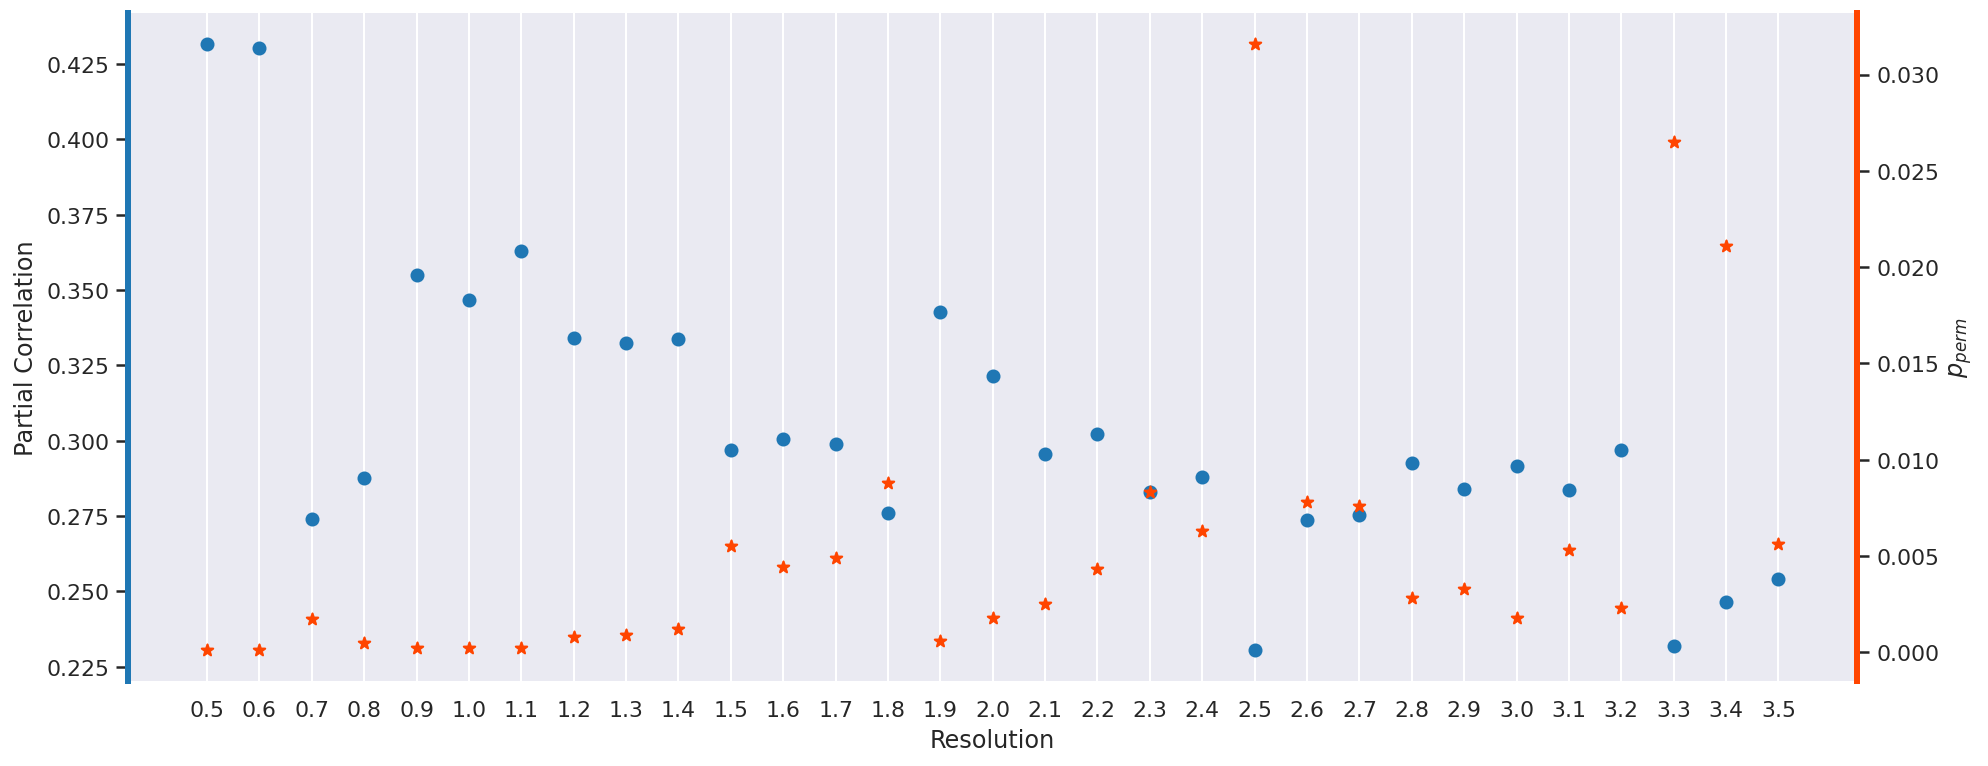

In [38]:
utils.plot_cart_test(sc_wd_vs_lag1_df.gamma, sc_wd_vs_lag1_df.r_val, sc_wd_vs_lag1_df.p_abs)

### Functional Connectivitity Participation Coefficient

In [39]:
fc_pc_vs_lag1_df = utils.run_cartography_tests(gamma_range, dat[PPtsnr_T10], fc_pc_df[PPtsnr_T10], 'lag1', 'fc_pc', 'roi_vols', lag1_vs_roiv_yhatperm[:,PPtsnr_T10])

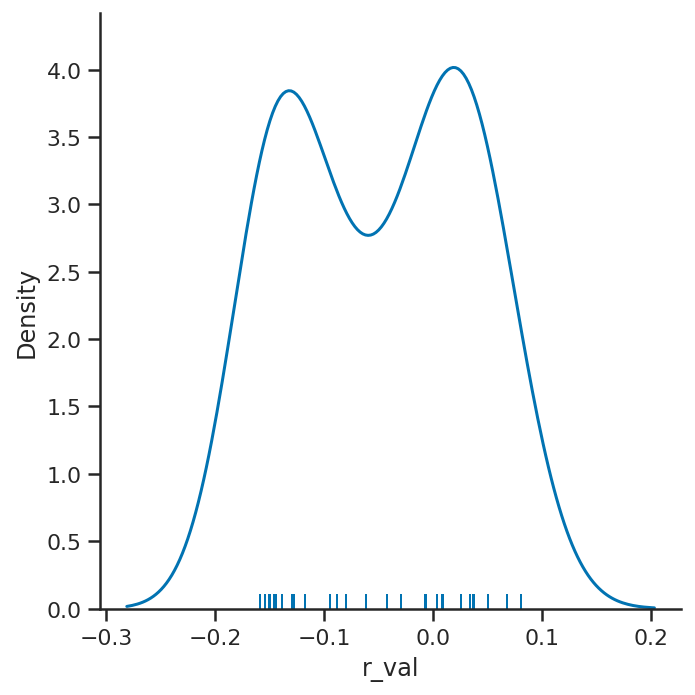

In [40]:
sns.set_style('ticks')
sns.displot(fc_pc_vs_lag1_df.r_val, kind='kde', rug=True)

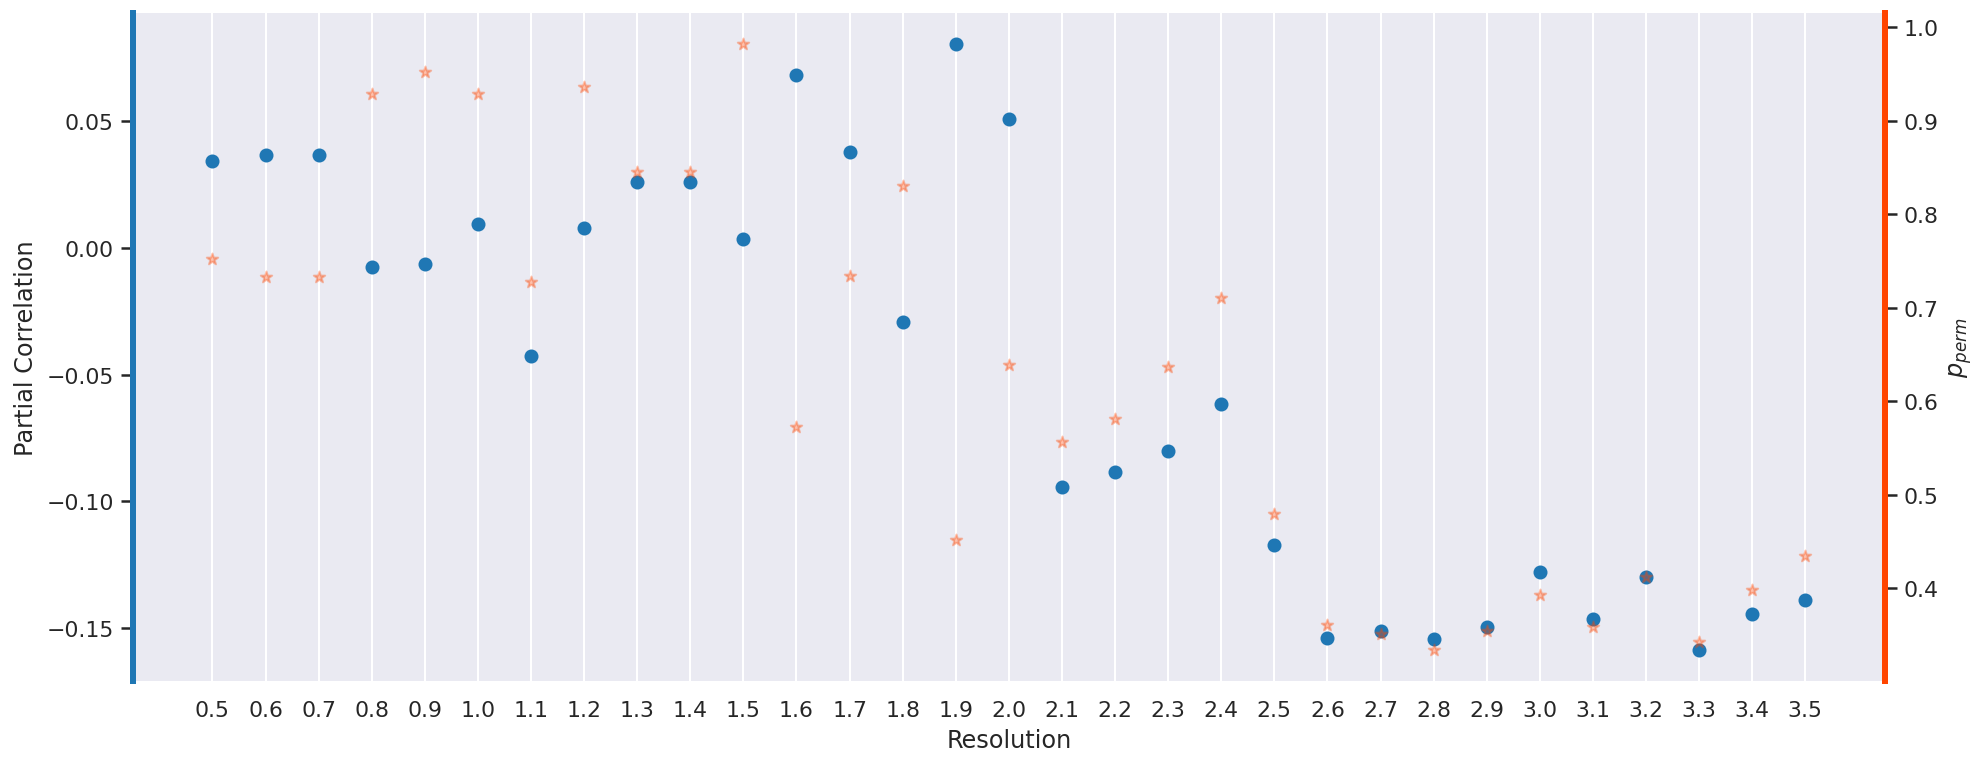

In [41]:
utils.plot_cart_test(fc_pc_vs_lag1_df.gamma, fc_pc_vs_lag1_df.r_val, fc_pc_vs_lag1_df.p_abs)

### Structural Connectivitity Participation Coefficient

In [42]:
sc_pc_vs_lag1_df = utils.run_cartography_tests(gamma_range, dat[PPtsnr_T10], sc_pc_df[PPtsnr_T10], 'lag1', 'sc_pc', 'roi_vols', lag1_vs_roiv_yhatperm[:,PPtsnr_T10])

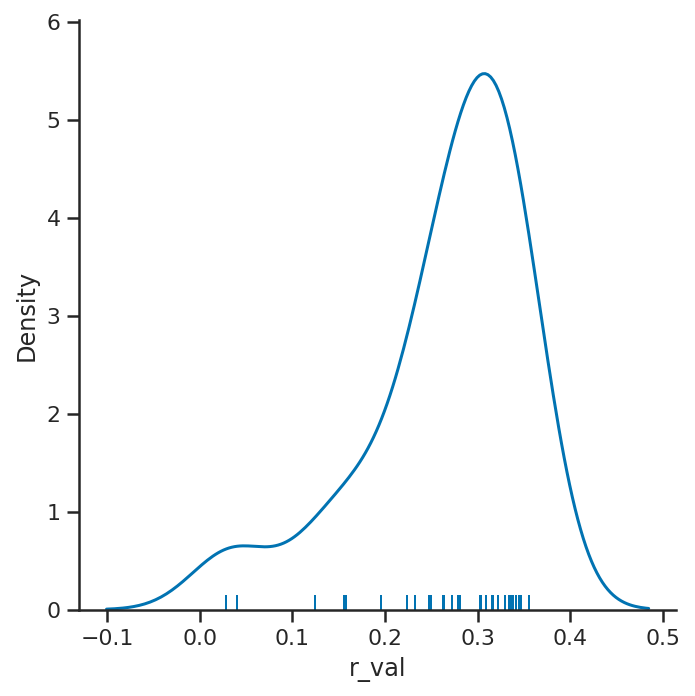

In [43]:
sns.set_style('ticks')
sns.displot(sc_pc_vs_lag1_df.r_val, kind='kde', rug=True)

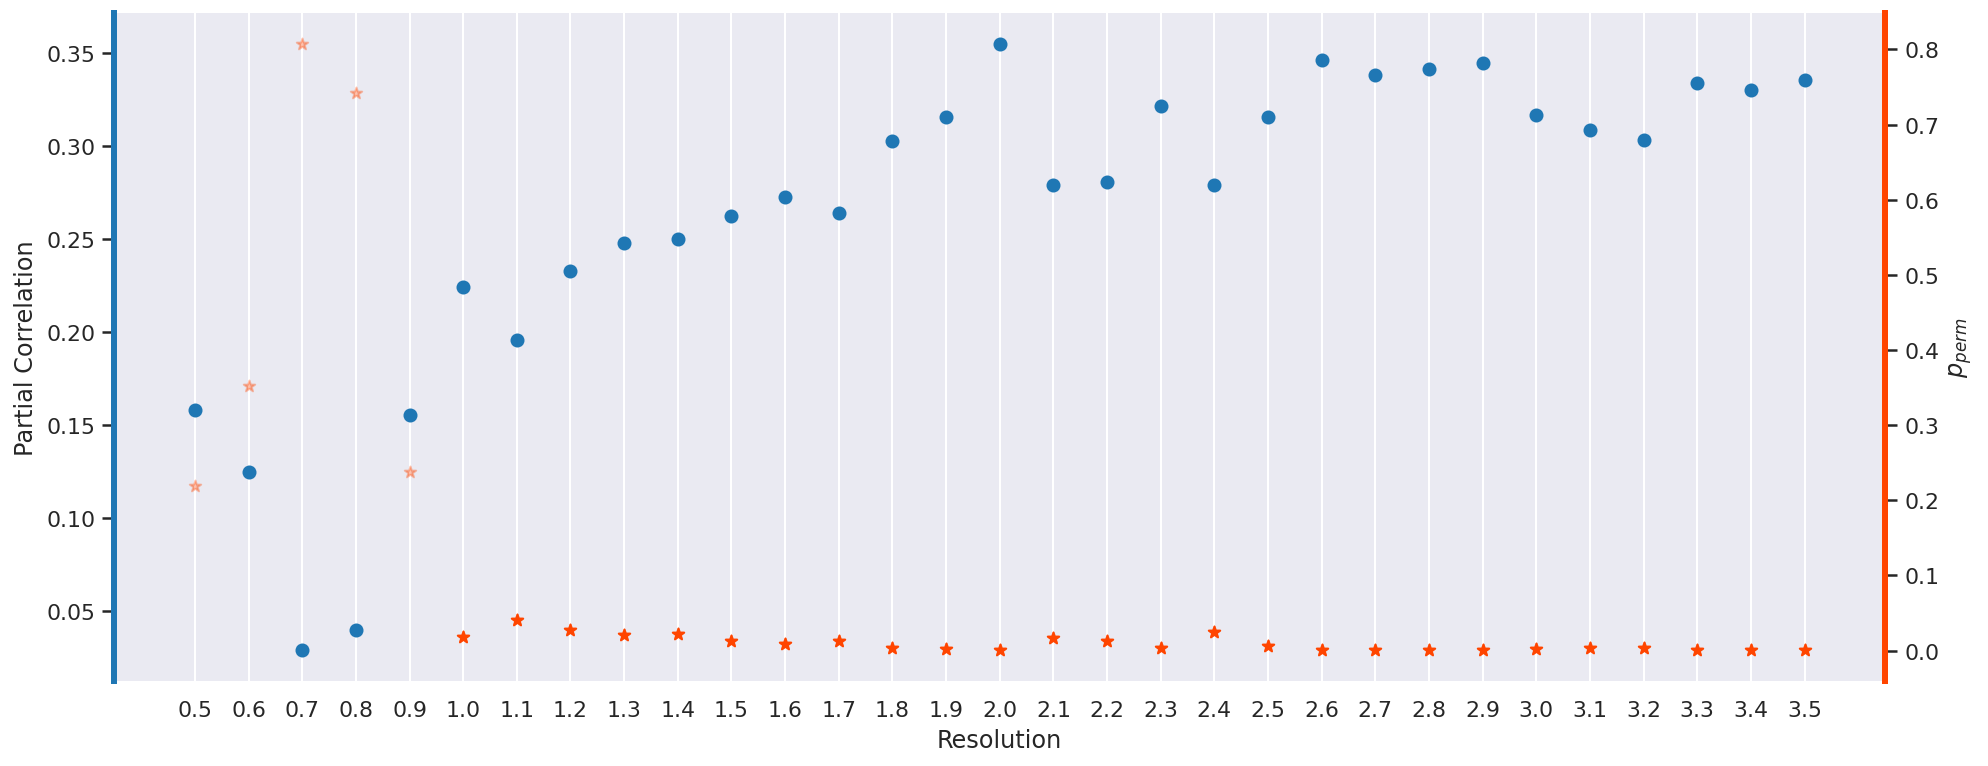

In [44]:
utils.plot_cart_test(sc_pc_vs_lag1_df.gamma, sc_pc_vs_lag1_df.r_val, sc_pc_vs_lag1_df.p_abs)

### T1w/T2w

In [45]:
if roi_subset == 'CX':
    lag1_vs_myelin_rval, lag1_vs_myelin_pvals, lag1_vs_myelin_model, lag1_vs_myelin_rnull = pm.freedman_lane(dat[PPtsnr_T10], 'lag1', 'myelin', 'roi_vols',
                                                                                                 stat='pcorr', n_perms=10000, perm_func=None,
                                                                                                 perm_func_args=None, surrogates=lag1_vs_roiv_yhatperm[:,PPtsnr_T10],
                                                                                                 return_null=True, return_surrogates=False)
else:
    print("Not Applicable") 

In [46]:
if roi_subset == 'CX':
    print(lag1_vs_myelin_rval)
else:
    print("Not Applicable")

0.07202978886718664


In [47]:
if roi_subset == 'CX':
    print(lag1_vs_myelin_pvals)
else:
    print("Not Applicable")

p_greater    0.390761
p_less       0.609339
p_abs        0.773723
dtype: float64


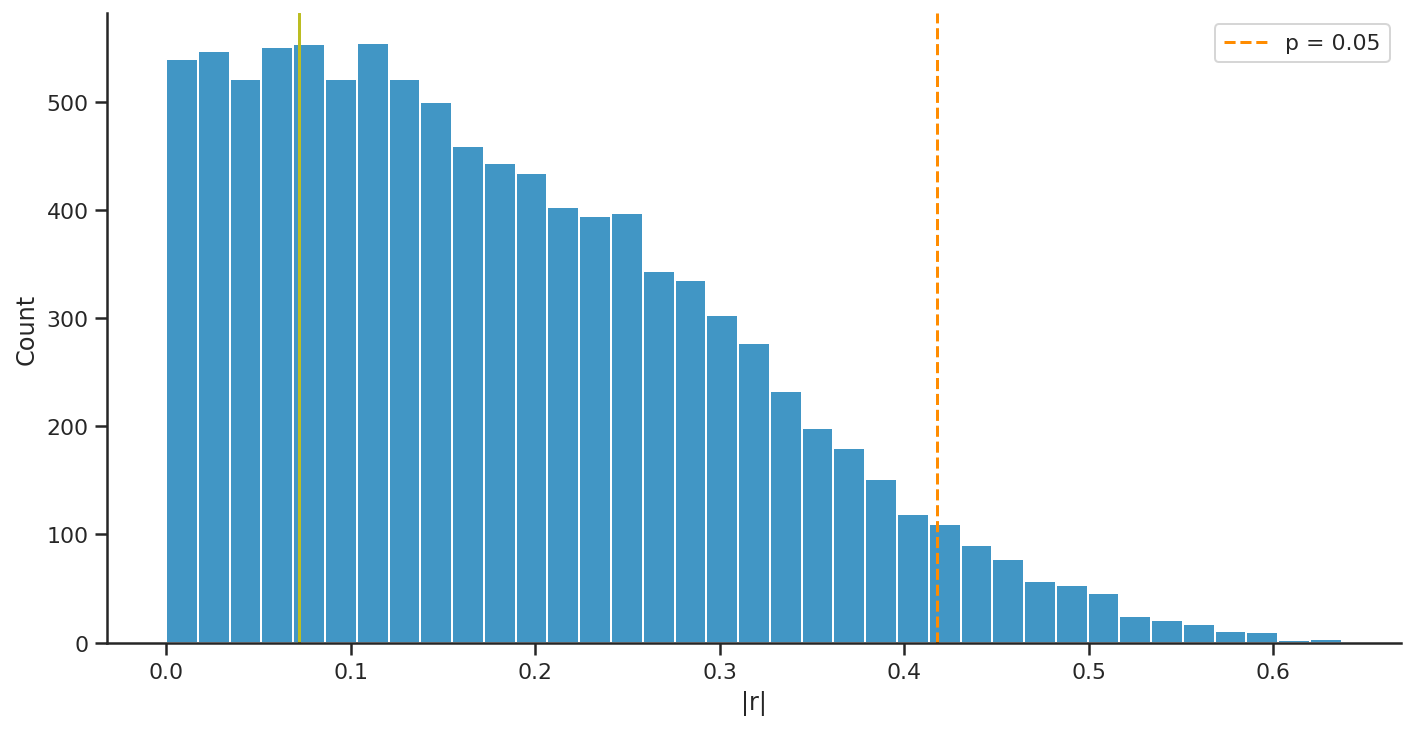

In [48]:
if roi_subset == 'CX':
    utils.plot_null_hist(lag1_vs_myelin_rval, lag1_vs_myelin_rnull)
else:
    print("Not Applicable")

### Cortical Thickness

In [49]:
if roi_subset == 'CX':
    lag1_vs_ct_rval, lag1_vs_ct_pvals, lag1_vs_ct_model, lag1_vs_ct_rnull = pm.freedman_lane(dat[PPtsnr_T10], 'lag1', 'ct', 'roi_vols',
                                                                                             stat='pcorr', n_perms=10000, perm_func=None,
                                                                                             perm_func_args=None, surrogates=lag1_vs_roiv_yhatperm[:,PPtsnr_T10],
                                                                                             return_null=True, return_surrogates=False)
else:
    print("Not Applicable")

In [50]:
if roi_subset == 'CX':
    print(lag1_vs_ct_rval)
else:
    print("Not Applicable")

-0.31540656343217627


In [51]:
if roi_subset == 'CX':
    print(lag1_vs_ct_pvals)
else:
    print("Not Applicable")

p_greater    0.936206
p_less       0.063894
p_abs        0.127687
dtype: float64


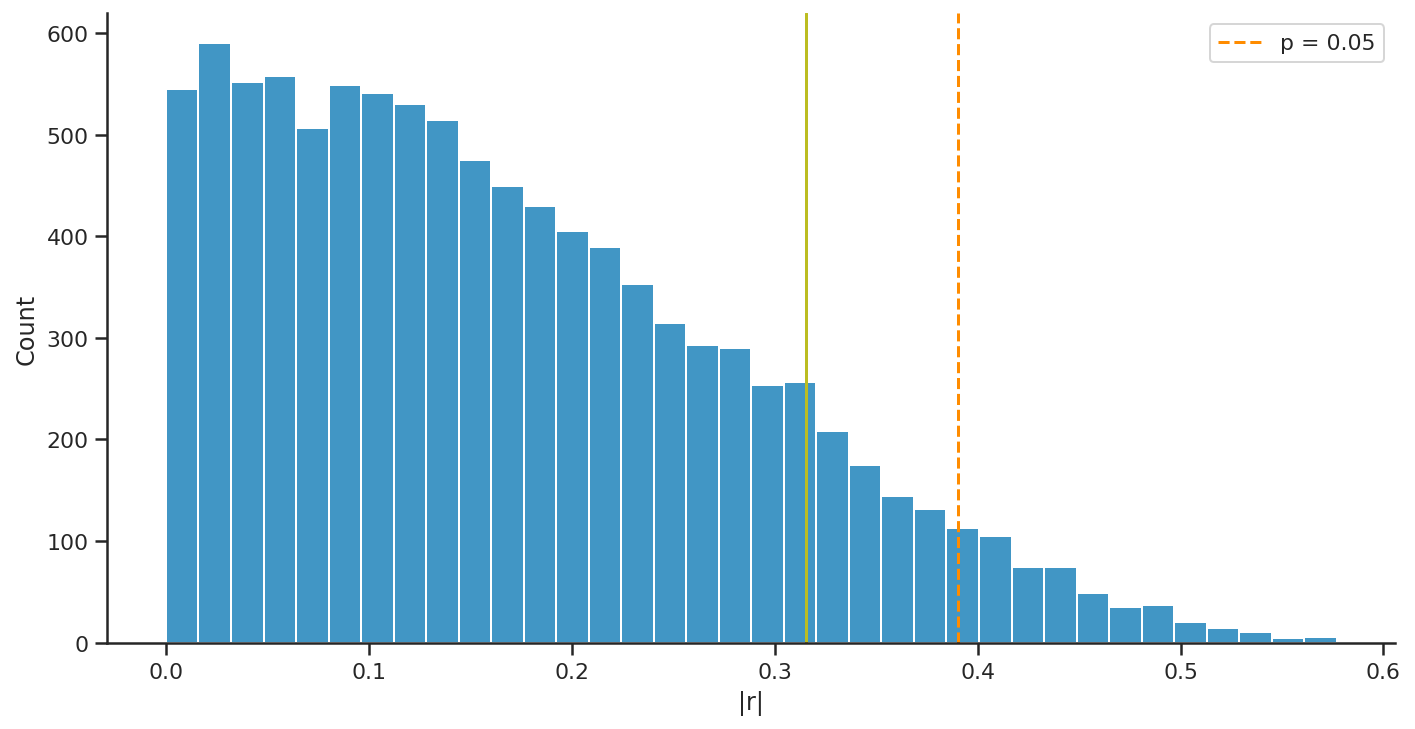

In [52]:
if roi_subset == 'CX':
    utils.plot_null_hist(lag1_vs_ct_rval, lag1_vs_ct_rnull)
else:
    print("Not Applicable")

### Gather p-values.

In [53]:
p_other = [lag1_vs_sck_pvals.p_abs, lag1_vs_fck_pvals.p_abs]

if roi_subset == 'CX':
    p_other.append(lag1_vs_myelin_pvals.p_abs)
    p_other.append(lag1_vs_ct_pvals.p_abs)

In [54]:
p_array = np.concatenate((sc_pc_vs_lag1_df.p_abs.values, fc_pc_vs_lag1_df.p_abs.values, sc_wd_vs_lag1_df.p_abs.values,
                          fc_wd_vs_lag1_df.p_abs.values, np.array(p_other)))

In [55]:
p_index = []
for j in ['sc_pc', 'fc_pc', 'sc_wd', 'fc_wd']:
    for i in gamma_range:
        p_index.append(j+'_'+str(i))
p_index.append('sc_strength')
p_index.append('fc_strength')

if roi_subset == 'CX':
    p_index.append('myelin')
    p_index.append('thickness')

In [56]:
p_series = pd.Series(p_array, index=p_index)

### Gather partial correlations.

In [57]:
r_other = [lag1_vs_sck_rval, lag1_vs_fck_rval]

if roi_subset == 'CX':
    r_other.append(lag1_vs_myelin_rval)
    r_other.append(lag1_vs_ct_rval)

In [58]:
r_array = np.concatenate((sc_pc_vs_lag1_df.r_val, fc_pc_vs_lag1_df.r_val, sc_wd_vs_lag1_df.r_val,
                          fc_wd_vs_lag1_df.r_val, np.array(r_other)))

In [59]:
r_df = pd.DataFrame(r_array, columns=['r-value'], index=p_index)

### Run FDR

In [60]:
q_vals = sm.stats.multipletests(p_series.values, alpha=0.05, method='fdr_bh')[1]

In [61]:
q_df = pd.DataFrame(q_vals, columns=['q-value'], index=p_index)

### Summary Plots

In [62]:
non_cart_labels = ['SC Strength', 'FC Strength']

if roi_subset == 'CX':
    non_cart_labels.append('T1w/T2w')
    non_cart_labels.append('Thickness')

In [63]:
annot_df, r_df_cart, annot_df_cart, r_df_other, annot_df_other = utils.prep_summary_plots(q_df, r_df, non_cart_labels)

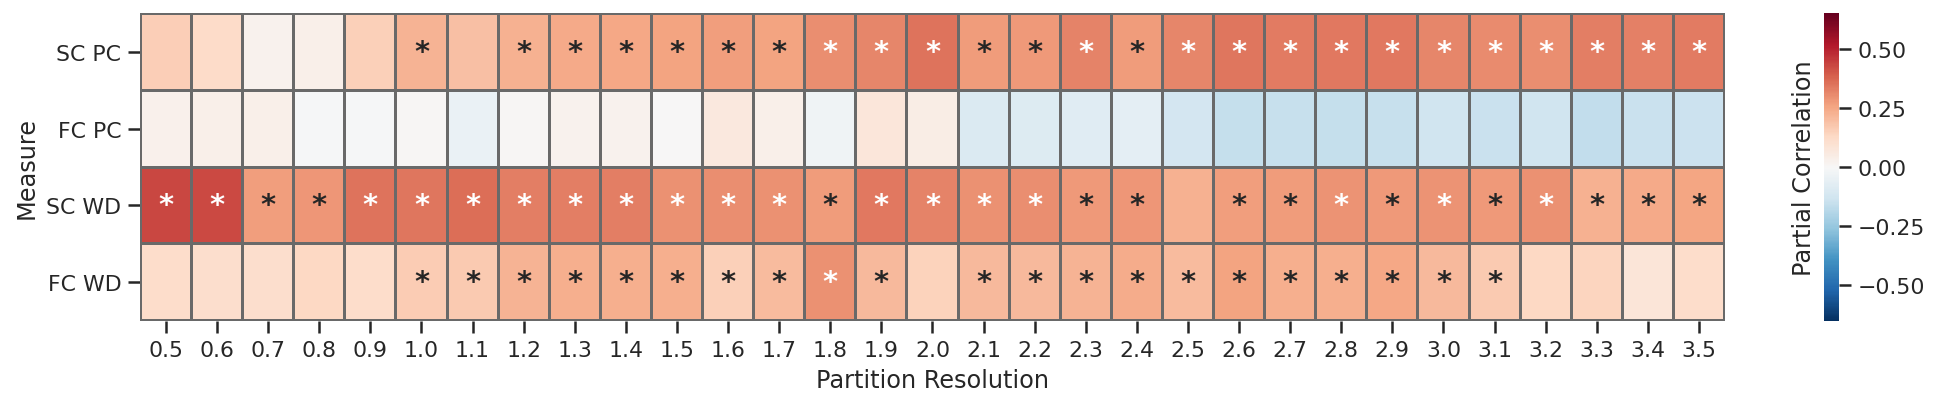

In [64]:
fig, ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(15,3))
sns.heatmap(r_df_cart, cbar=True, linewidths=1, cmap='RdBu_r', vmin=-0.65,
            vmax=0.65, linecolor='dimgrey', ax=ax1, annot=annot_df_cart, 
            fmt='', annot_kws={'fontweight':'black', 'fontsize':'large'}, 
            cbar_kws={'label':'Partial Correlation'})
colorbar = ax1.collections[0].colorbar
colorbar.ax.yaxis.set_label_position('left')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.xlabel('Partition Resolution')
plt.ylabel('Measure')
plt.tight_layout()

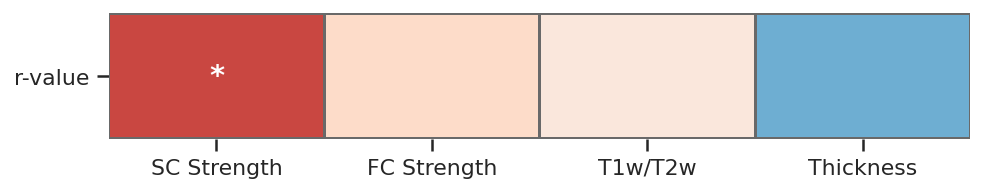

In [65]:
fig, ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(7,1.5))
sns.heatmap(r_df_other.T, cbar=False, linewidths=1, cmap='RdBu_r', vmin=-0.65,
            vmax=0.65, linecolor='dimgrey', ax=ax1, annot=annot_df_other.T,
            fmt='', annot_kws={'fontweight':'black', 'fontsize':'large'})
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()

### Plot Timescale Associations

#### FC K

In [66]:
sns.set_style('ticks')

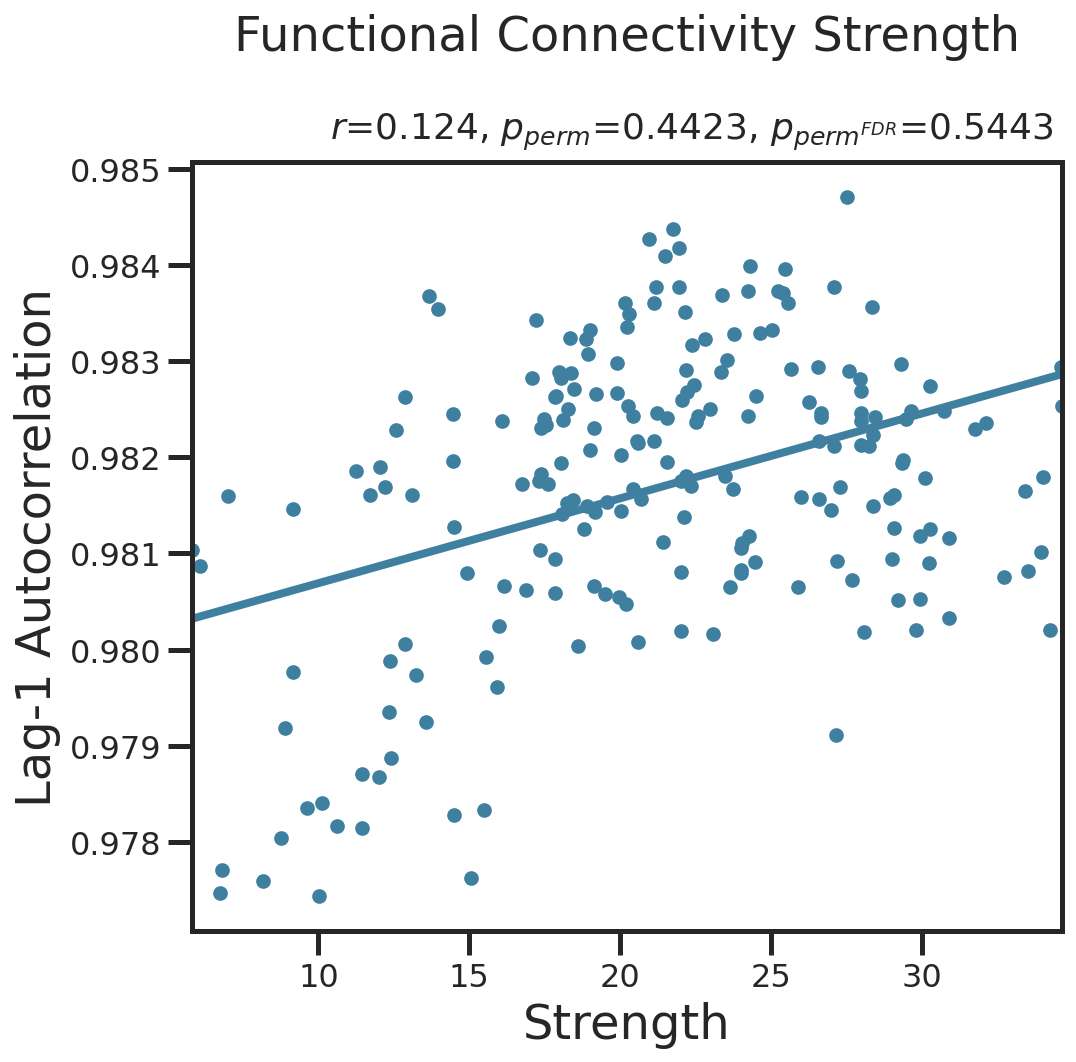

In [67]:
utils.plot_ta_partial(x=dat.fc_strength.values, xlabel='Strength',
                y=dat.lag1.values, ylabel='Lag-1 Autocorrelation',
                covar=dat.roi_vols.values,
                rval=r_df.loc['fc_strength'].values[0],
                pval=p_series.fc_strength, qval=q_df.loc['fc_strength'].values[0],
                color='#3F80A1', title='Functional Connectivity Strength')

#### SC K

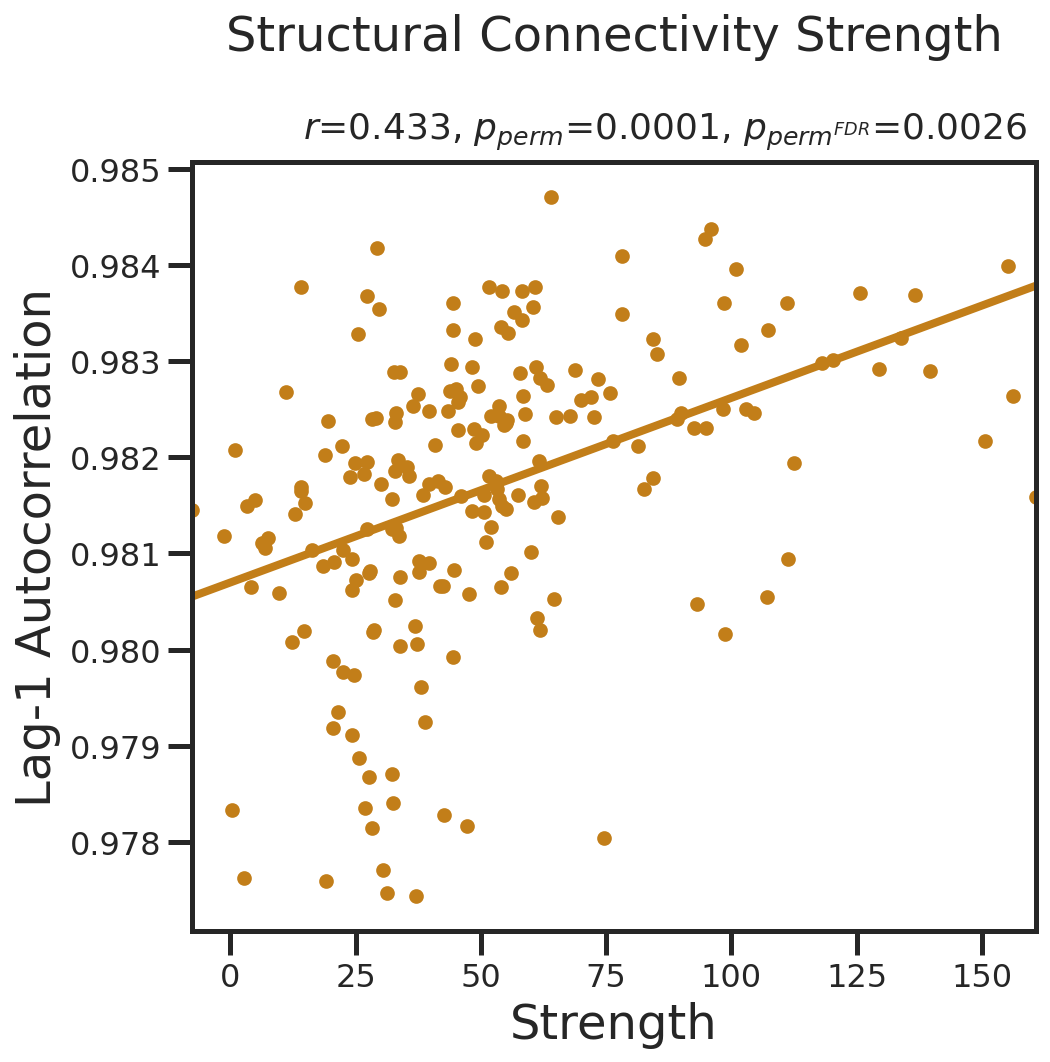

In [68]:
utils.plot_ta_partial(x=dat.sc_strength.values, xlabel='Strength',
                y=dat.lag1.values, ylabel='Lag-1 Autocorrelation',
                covar=dat.roi_vols.values,
                rval=r_df.loc['sc_strength'].values[0],
                pval=p_series.sc_strength, qval=q_df.loc['sc_strength'].values[0],
                color='#C27E19', title='Structural Connectivity Strength')

#### FC PC

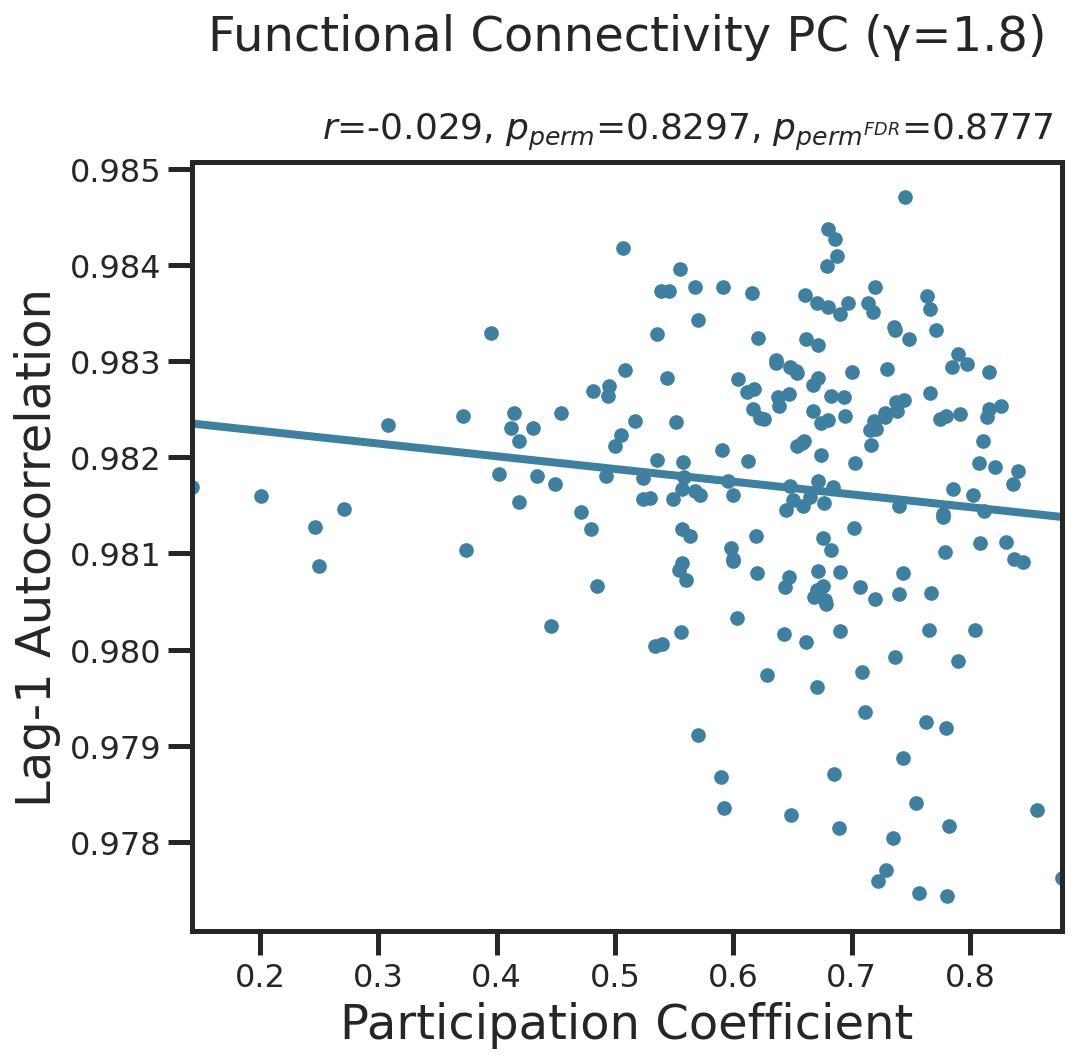

In [69]:
utils.plot_ta_partial(x=fc_pc_df['1.8'].values, xlabel='Participation Coefficient',
                y=dat.lag1.values, ylabel='Lag-1 Autocorrelation',
                covar=dat.roi_vols.values,
                rval=r_df.loc['fc_pc_1.8'].values[0],
                pval=p_series['fc_pc_1.8'], qval=q_df.loc['fc_pc_1.8'].values[0],
                color='#3F80A1', title='Functional Connectivity PC (γ=1.8)')

#### SC PC

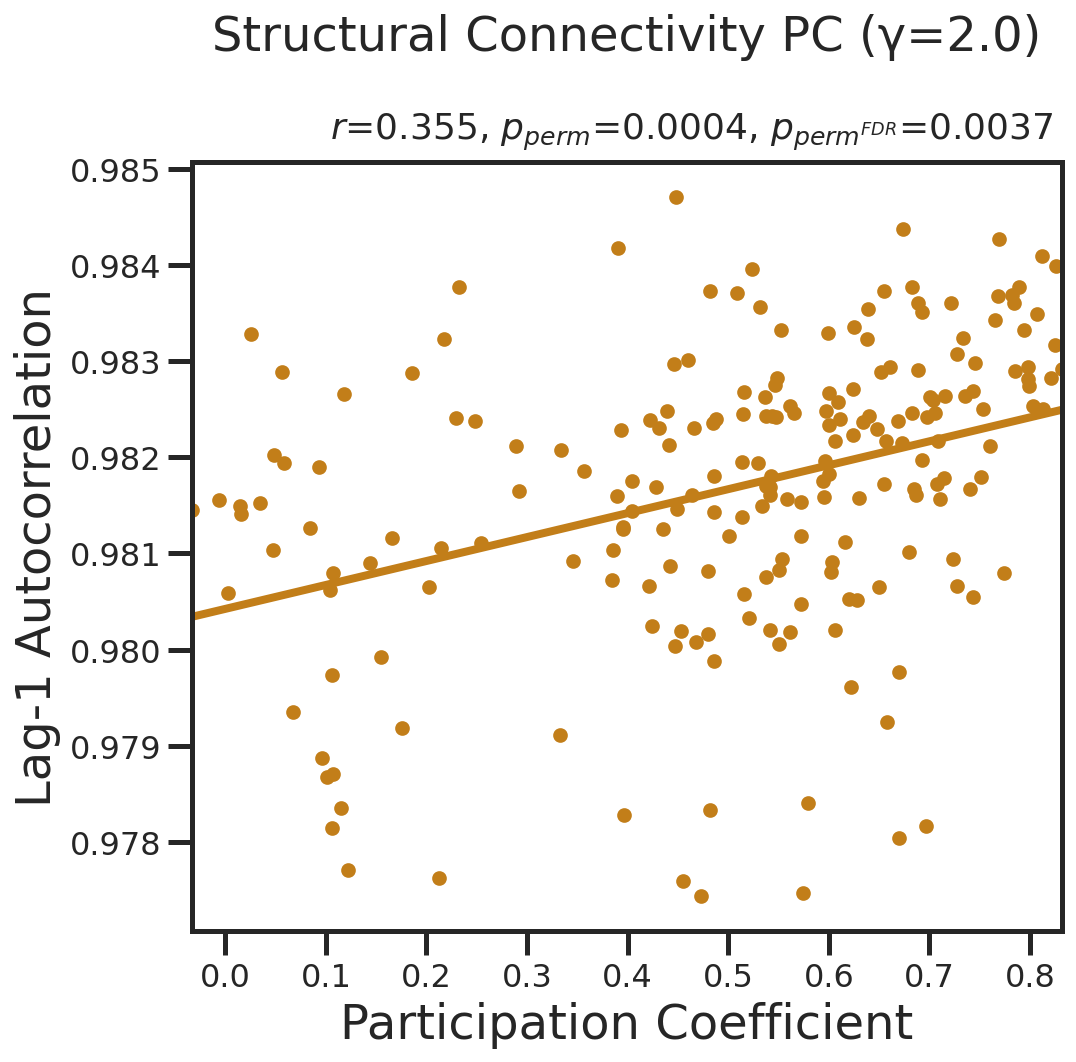

In [70]:
utils.plot_ta_partial(x=sc_pc_df['2.0'].values, xlabel='Participation Coefficient',
                y=dat.lag1.values, ylabel='Lag-1 Autocorrelation',
                covar=dat.roi_vols.values,
                rval=r_df.loc['sc_pc_2.0'].values[0],
                pval=p_series['sc_pc_2.0'], qval=q_df.loc['sc_pc_2.0'].values[0],
                color='#C27E19', title='Structural Connectivity PC (γ=2.0)')

#### FC WD

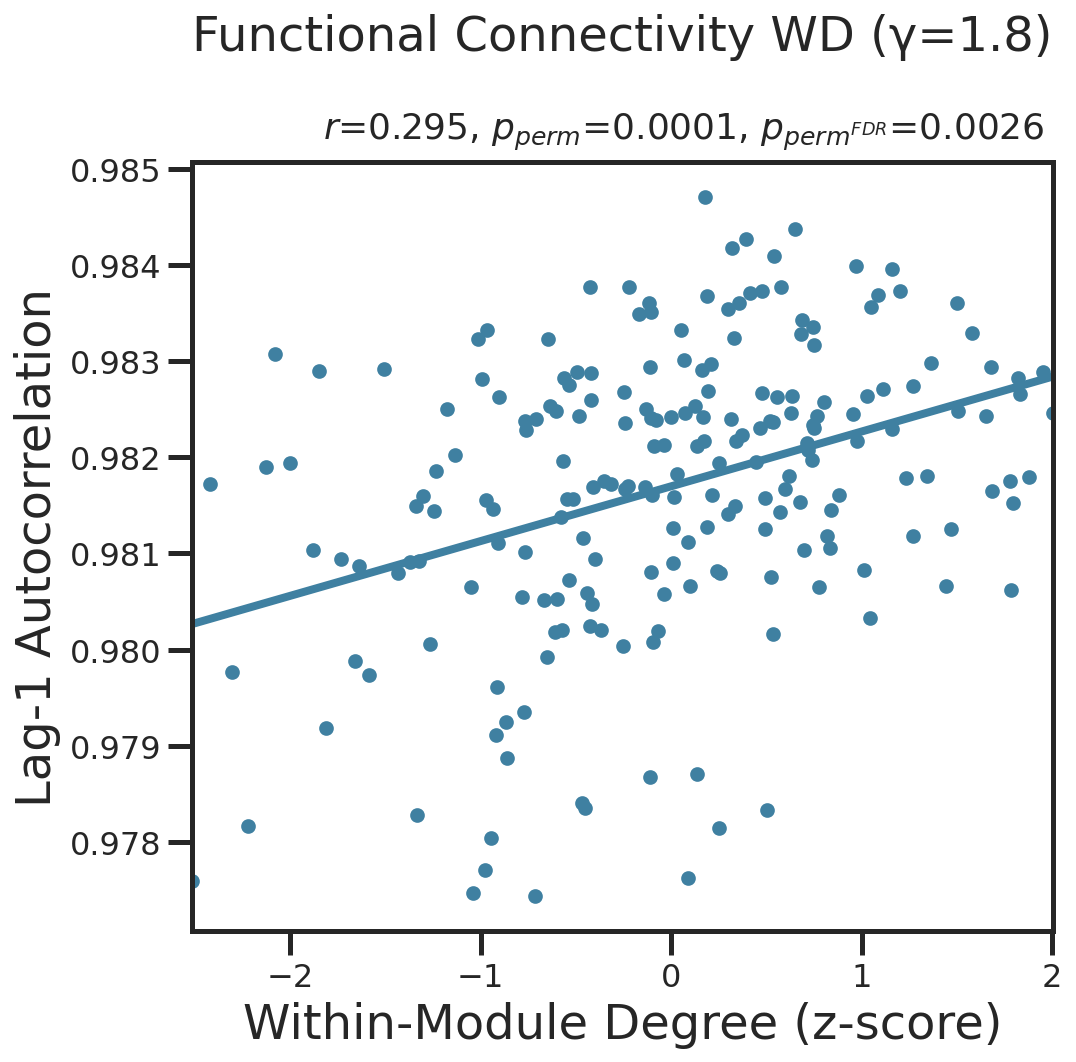

In [71]:
utils.plot_ta_partial(x=fc_wd_df['1.8'].values, xlabel='Within-Module Degree (z-score)',
                y=dat.lag1.values, ylabel='Lag-1 Autocorrelation',
                covar=dat.roi_vols.values,
                rval=r_df.loc['fc_wd_1.8'].values[0],
                pval=p_series['fc_wd_1.8'], qval=q_df.loc['fc_wd_1.8'].values[0],
                color='#3F80A1', title='Functional Connectivity WD (γ=1.8)')

#### SC WD

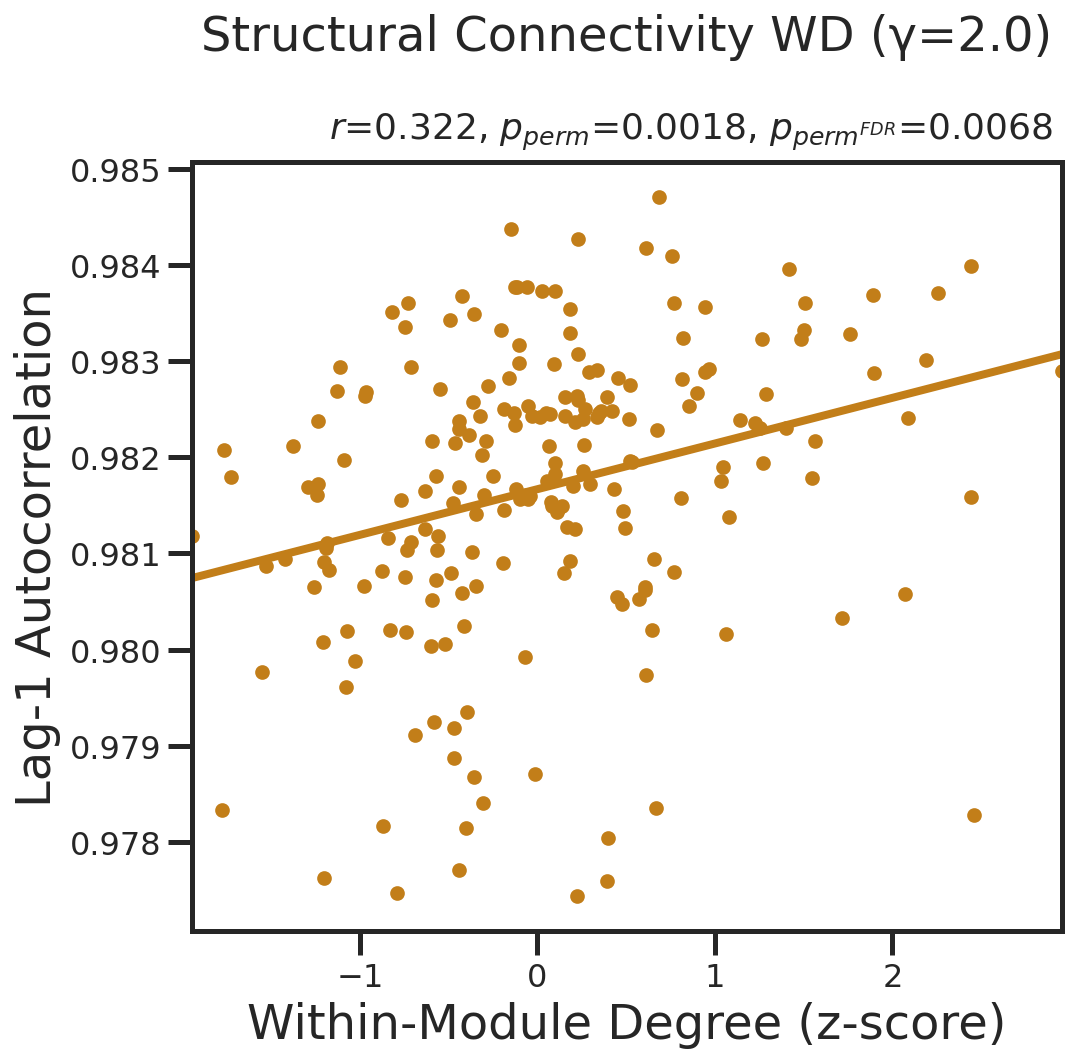

In [72]:
utils.plot_ta_partial(x=sc_wd_df['2.0'].values, xlabel='Within-Module Degree (z-score)',
                y=dat.lag1.values, ylabel='Lag-1 Autocorrelation',
                covar=dat.roi_vols.values,
                rval=r_df.loc['sc_wd_2.0'].values[0],
                pval=p_series['sc_wd_2.0'], qval=q_df.loc['sc_wd_2.0'].values[0],
                color='#C27E19', title='Structural Connectivity WD (γ=2.0)')

#### Cortical Thickness

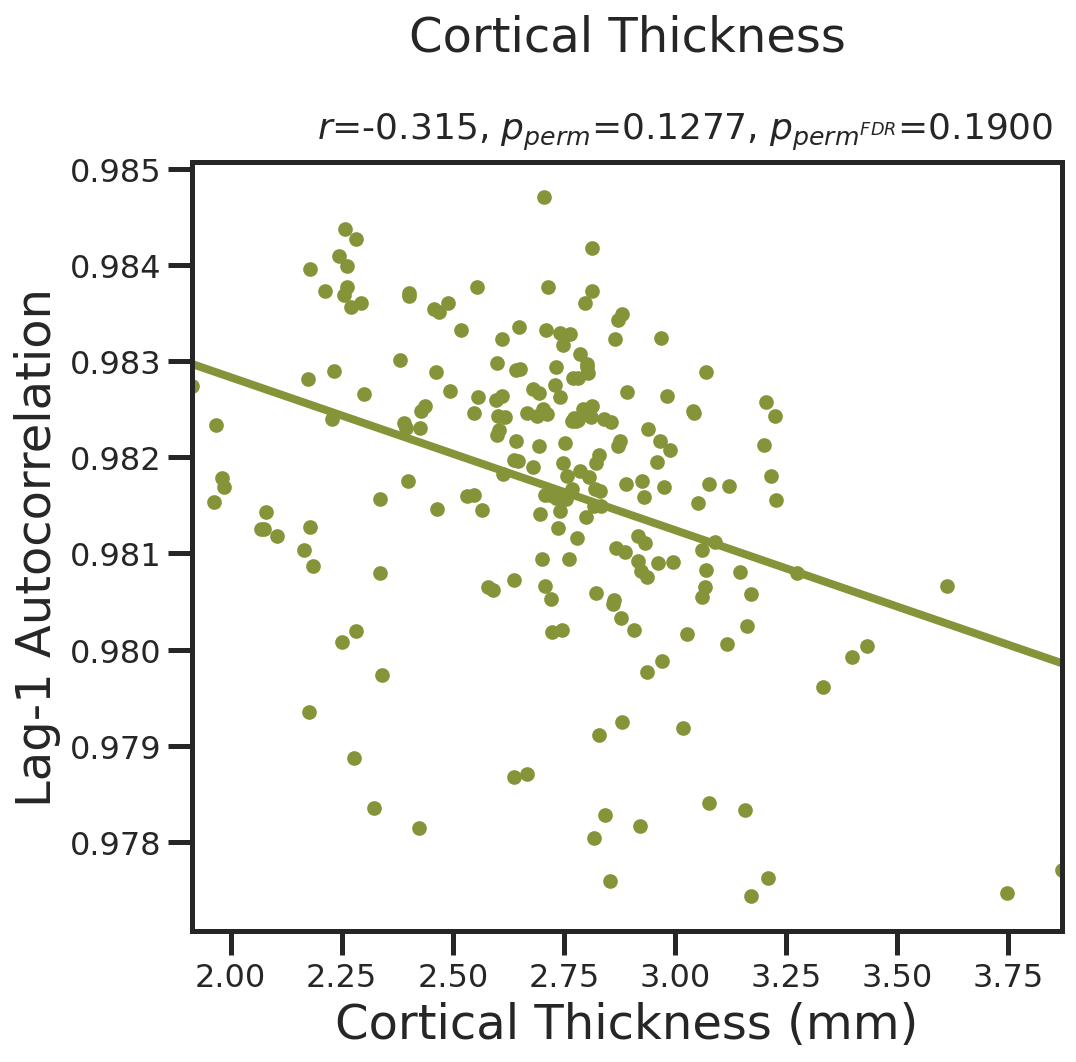

In [73]:
if roi_subset == 'CX':
    utils.plot_ta_partial(x=dat.ct.values, xlabel='Cortical Thickness (mm)',
                    y=dat.lag1.values, ylabel='Lag-1 Autocorrelation',
                    covar=dat.roi_vols.values,
                    rval=r_df.loc['thickness'].values[0],
                    pval=p_series.thickness, qval=q_df.loc['thickness'].values[0],
                    color='#859438', title='Cortical Thickness')
else:
    print('Not Applicable')

#### T1w/T2w MRI

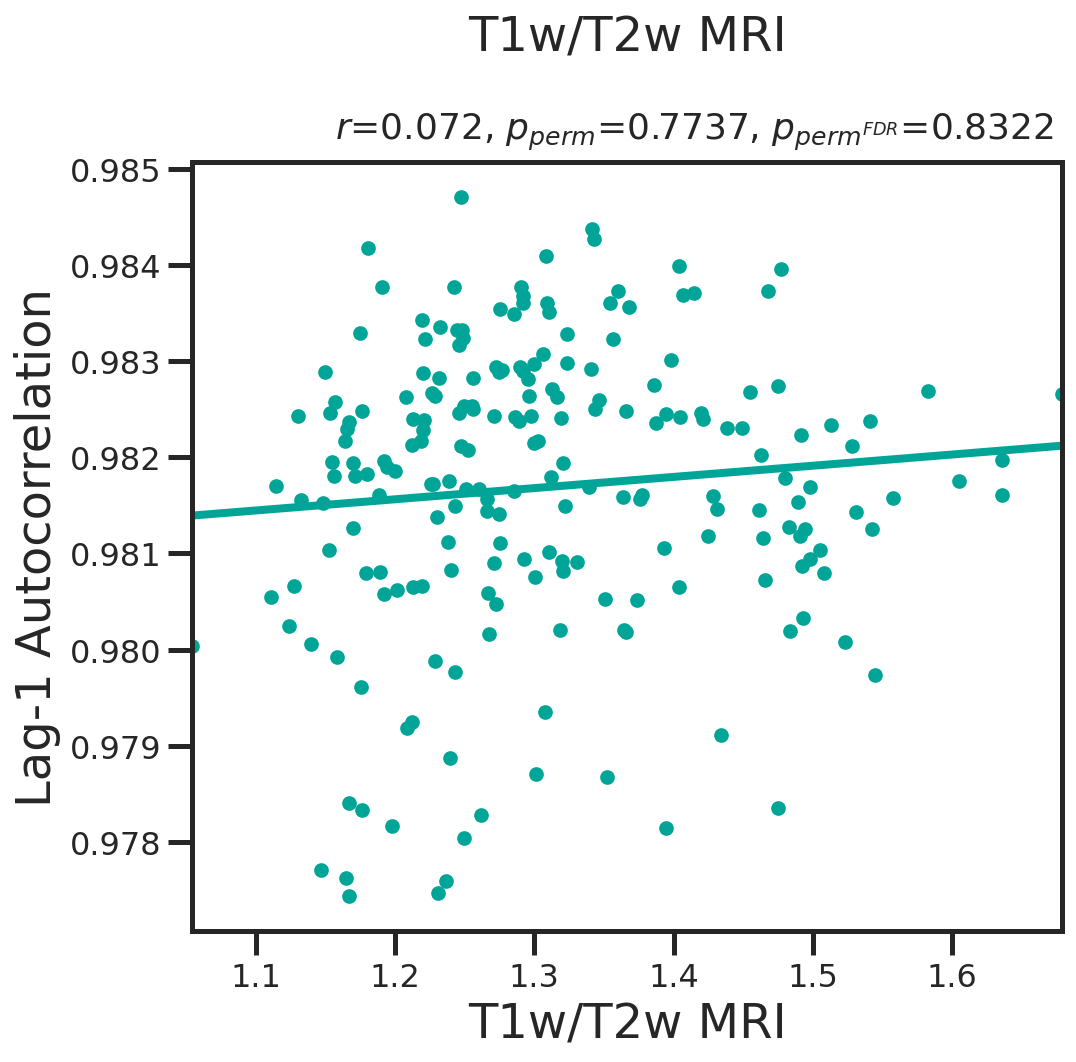

In [74]:
if roi_subset == 'CX':
    utils.plot_ta_partial(x=dat.myelin.values, xlabel='T1w/T2w MRI',
                y=dat.lag1.values, ylabel='Lag-1 Autocorrelation',
                covar=dat.roi_vols.values,
                rval=r_df.loc['myelin'].values[0],
                pval=p_series.myelin, qval=q_df.loc['myelin'].values[0],
                color='#00A598', title='T1w/T2w MRI')
else:
    print('Not Applicable')